<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2025-2/blob/main/DL_day11/11_2_longhorizon_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long-Horizon Forecasting with Transformer models
> Tutorial on how to train and forecast Transformer models.

Reference: https://nixtlaverse.nixtla.io/neuralforecast/docs/tutorials/longhorizon_transformers.html

Transformer models, originally proposed for applications in natural language processing, have seen increasing adoption in the field of time series forecasting. The transformative power of these models lies in their novel architecture that relies heavily on the self-attention mechanism, which helps the model to focus on different parts of the input sequence to make predictions, while capturing long-range dependencies within the data. In the context of time series forecasting, Transformer models leverage this self-attention mechanism to identify relevant information across different periods in the time series, making them exceptionally effective in predicting future values for complex and noisy sequences.

Long horizon forecasting consists of predicting a large number of timestamps. It is a challenging task because of the *volatility* of the predictions and the *computational complexity*. To solve this problem, recent studies proposed a variety of Transformer-based models.

The Neuralforecast library includes implementations of the following popular recent models: `Informer` (Zhou, H. et al. 2021), `Autoformer` (Wu et al. 2021), `FEDformer` (Zhou, T. et al. 2022), and `PatchTST` (Nie et al. 2023).

Our implementation of all these models are univariate, meaning that only autoregressive values of each feature are used for forecasting. **We observed that these unvivariate models are more accurate and faster than their multivariate couterpart**.

In this notebook we will show how to:
* Load the [ETTm2](https://github.com/zhouhaoyi/ETDataset) benchmark dataset, used in the academic literature.
* Train models
* Forecast the test set

**The results achieved in this notebook outperform the original self-reported results in the respective original paper, with a fraction of the computational cost. Additionally, all models are trained with the default recommended parameters, results can be further improved using our `auto` models with automatic hyperparameter selection.**

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/LongHorizon_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing libraries

In [1]:
%%capture
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0

In [2]:
%%capture
!pip install neuralforecast datasetsforecast

## 2. Load ETTm2 Data

The `LongHorizon` class will automatically download the complete ETTm2 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for ETTm2). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [3]:
import pandas as pd

from datasetsforecast.long_horizon import LongHorizon

In [4]:
# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


## 3. Train models

We will train models using the `cross_validation` method, which allows users to automatically simulate multiple historic forecasts (in the test set).

The `cross_validation` method will use the validation set for hyperparameter selection and early stopping, and will then produce the forecasts for the test set.

First, instantiate each model in the `models` list, specifying the `horizon`, `input_size`, and training iterations.

(NOTE: The `FEDformer` model was excluded due to extremely long training times.)

In [5]:
%%capture
from neuralforecast.core import NeuralForecast
from neuralforecast.models import Informer, Autoformer, FEDformer, PatchTST

In [6]:
%%capture
horizon = 96 # 24hrs = 4 * 15 min.
models = [Informer(h=horizon,                 # Forecasting horizon
                input_size=horizon,           # Input size
                max_steps=1000,               # Number of training iterations
                val_check_steps=100,          # Compute validation loss every 100 steps
                early_stop_patience_steps=3), # Stop training if validation loss does not improve
          Autoformer(h=horizon,
                input_size=horizon,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=3),
          PatchTST(h=horizon,
                input_size=horizon,
                max_steps=1000,
                val_check_steps=100,
                early_stop_patience_steps=3),
         ]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


:::{.callout-tip}
Check our `auto` models for automatic hyperparameter optimization.
:::

Instantiate a `NeuralForecast` object with the following required parameters:

* `models`: a list of models.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

Second, use the `cross_validation` method, specifying the dataset (`Y_df`), validation size and test size.

In [7]:
nf = NeuralForecast(
    models=models,
    freq='15min')

Y_hat_df = nf.cross_validation(df=Y_df,
                               val_size=val_size,
                               test_size=test_size,
                               n_windows=None)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 384    | train
4 | dec_embedding | DataEmbedding | 384    | train
5 | encoder       | TransEncoder  | 199 K  | train
6 | decoder       | TransDecoder  | 141 K  | train
--------------------------------------------------------
341 K     Trainable params
0         Non-trainable params
341 K     Total params
1.368     Total estim

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 148 K  | train
7 | decoder       | Decoder       | 141 K  | train
--------------------------------------------------------
290 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MAE               | 0      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 548 K  | train
-----------------------------------------------------------
548 K     Trainable params
3         Non-trainable params
548 K     Total params
2.195     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

The `cross_validation` method will return the forecasts for each model on the test set.

In [8]:
Y_hat_df.head()

,unique_id,ds,cutoff,Informer,Autoformer,PatchTST,y
0,HUFL,2017-10-24 00:00:00,2017-10-23 23:45:00,-1.144987,-0.863746,-0.867246,-0.977673
1,HUFL,2017-10-24 00:15:00,2017-10-23 23:45:00,-1.142592,-0.883830,-0.874153,-0.865620
2,HUFL,2017-10-24 00:30:00,2017-10-23 23:45:00,-1.132315,-0.930621,-0.957323,-0.961624
3,HUFL,2017-10-24 00:45:00,2017-10-23 23:45:00,-1.114669,-0.943253,-0.981435,-1.049700
4,HUFL,2017-10-24 01:00:00,2017-10-23 23:45:00,-1.097951,-0.971587,-1.015632,-0.953600


## 4. Evaluate Results

Next, we plot the forecasts on the test set for the `OT` variable for all models.

In [9]:
import matplotlib.pyplot as plt

/tmp/ipython-input-4193278075.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]


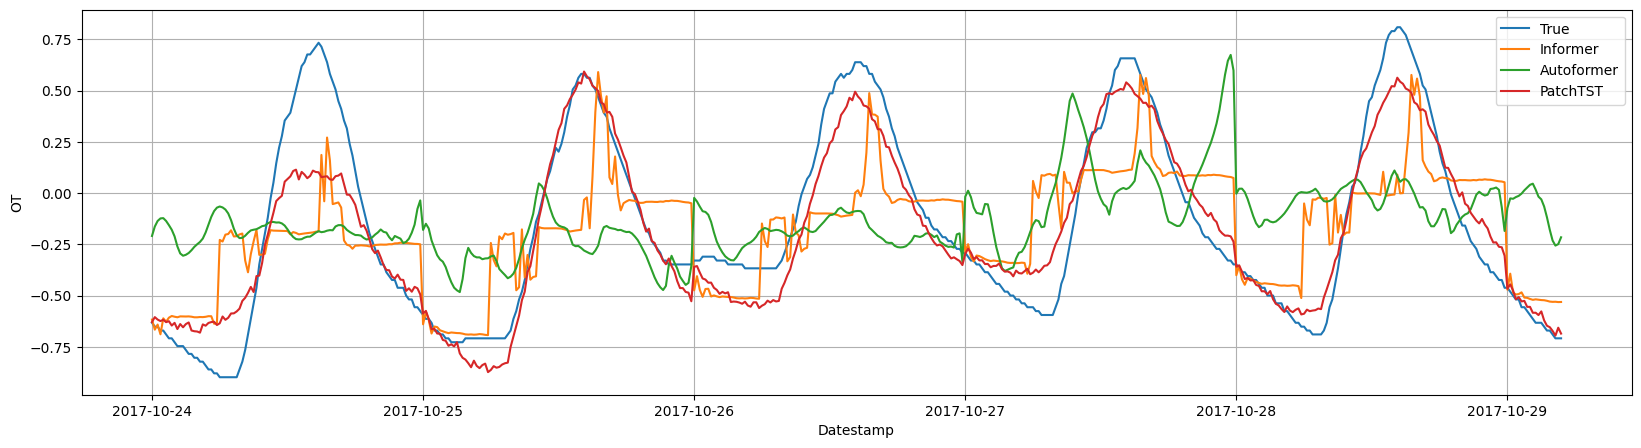

In [10]:
Y_plot = Y_hat_df[Y_hat_df['unique_id']=='OT'] # OT dataset
cutoffs = Y_hat_df['cutoff'].unique()[::horizon]
Y_plot = Y_plot[Y_hat_df['cutoff'].isin(cutoffs)]

start = 0
end = 500

plt.figure(figsize=(20,5))
plt.plot(Y_plot['ds'][start:end], Y_plot['y'][start:end], label='True')
plt.plot(Y_plot['ds'][start:end], Y_plot['Informer'][start:end], label='Informer')
plt.plot(Y_plot['ds'][start:end], Y_plot['Autoformer'][start:end], label='Autoformer')
plt.plot(Y_plot['ds'][start:end], Y_plot['PatchTST'][start:end], label='PatchTST')
plt.xlabel('Datestamp')
plt.ylabel('OT')
plt.grid()
plt.legend()

Finally, we compute the test errors using the Mean Absolute Error (MAE):

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$

In [11]:
from neuralforecast.losses.numpy import mae

In [12]:
mae_informer = mae(Y_hat_df['y'], Y_hat_df['Informer'])
mae_autoformer = mae(Y_hat_df['y'], Y_hat_df['Autoformer'])
mae_patchtst = mae(Y_hat_df['y'], Y_hat_df['PatchTST'])

print(f'Informer: {mae_informer:.3f}')
print(f'Autoformer: {mae_autoformer:.3f}')
print(f'PatchTST: {mae_patchtst:.3f}')

Informer: 0.366
Autoformer: 0.316
PatchTST: 0.251


For reference, we can check the performance when compared to self-reported performance in their respective papers.

| Horizon   | PatchTST     | AutoFormer | Informer | ARIMA
|---        |---           |---         |---       |---
|  96       |  **0.256**   |   0.339    |  0.453   | 0.301
|  192      |  0.296       |   0.340    |  0.563   | 0.345
|  336      |  0.329       |   0.372    |  0.887   | 0.386
|  720      |  0.385       |   0.419    |  1.388   | 0.445

## Next steps

We proposed an alternative model for long-horizon forecasting, the `NHITS`, based on feed-forward networks in (Challu et al. 2023). It achieves on par performance with `PatchTST`, with a fraction of the computational cost. The `NHITS` tutorial is available [here](https://nixtla.github.io/neuralforecast/examples/longhorizon_with_nhits.html).

## References

[Zhou, H., Zhang, S., Peng, J., Zhang, S., Li, J., Xiong, H., & Zhang, W. (2021, May). Informer: Beyond efficient transformer for long sequence time-series forecasting. In Proceedings of the AAAI conference on artificial intelligence (Vol. 35, No. 12, pp. 11106-11115)](https://ojs.aaai.org/index.php/AAAI/article/view/17325)

[Wu, H., Xu, J., Wang, J., & Long, M. (2021). Autoformer: Decomposition transformers with auto-correlation for long-term series forecasting. Advances in Neural Information Processing Systems, 34, 22419-22430.](https://proceedings.neurips.cc/paper/2021/hash/bcc0d400288793e8bdcd7c19a8ac0c2b-Abstract.html)

[Zhou, T., Ma, Z., Wen, Q., Wang, X., Sun, L., & Jin, R. (2022, June). Fedformer: Frequency enhanced decomposed transformer for long-term series forecasting. In International Conference on Machine Learning (pp. 27268-27286). PMLR.](https://proceedings.mlr.press/v162/zhou22g.html)


[Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2022). A Time Series is Worth 64 Words: Long-term Forecasting with Transformers.](https://arxiv.org/pdf/2211.14730.pdf)

[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)